# Wave with periodic bc with the scheme from Palma

We solve the wave equation with Dirichlet boundary conditions (homogeneous) up to $T = 2L$ where $L$ is the space size of the integrating region. The data is reflection symmetric, $u_0(x) = u_0(L-x)$, $\partial_t u(x,t=0) = 0$. This way at the last point the solution repeats itself and we can measure the error very well.

In [1]:
import Pkg
#Pkg.add("Zygote")
#Pkg.instantiate()
#Pkg.add("StatsBase")
#Pkg.add("UnPack")
#Pkg.add("Revise")
using ComponentArrays
using Distributions
#using WGLMakie
using Lux
using LuxCUDA
using Optim
using OptimizationOptimJL
using Random
using UnPack
using Zygote
#using CairoMakie  # Backend que funciona en notebooks
using StatsBase
using Revise
using Plots
using JLD2
using NBInclude
#import NaNMath

## Status:

Working well in both GPU and CPU without adaptivity. Using both initial data for u and its derivative.

I put some functions here.

In [2]:
includet("../neural_tools.jl")
includet("config_reg.jl")

In [3]:

config = config_basic
#config = config_test  # switch to config for real run

@show get_parameter_count(config)


get_parameter_count(config) = 481


481

In [4]:
@unpack p, A = config
f(x) = A*sin(π*x*p)

f (generic function with 1 method)

In [5]:

```
Residual at collocation points
``` 

function residual_at_points(input, NN, Θ, st)
    x = input[1:1, :]
    nn_in = vcat(x)
    #println(x)
    nn_out = NN(nn_in, Θ, st)[1]
    #println(nn_out)
    res = nn_out - f.(x)
    #res = res ./ abs_res
    return res
end


# -------------------------------------------------------------------
# Loss function with Dirichlet boundary conditions hard enforced.
# -------------------------------------------------------------------

function loss_function(input, NN, Θ, st)
    res = residual_at_points(input, NN, Θ, st)
    #return log10(sum(abs2, res) / length(res))
    #return log10(sum(abs, res) / length(res))
    return sum(abs2, res) / length(res)
end

# -------------------------------------------------------------------
# Callback
# -------------------------------------------------------------------
function callback(p, l, losses)
    println("Current loss: ", l)
    push!(losses, log10(l))
    return false
end

callback (generic function with 1 method)

In [7]:
#loss_function(input_total, NN, Θ, st)

┌ Warning: No functional GPU backend found! Defaulting to CPU.
│ 
│ 1. If no GPU is available, nothing needs to be done. Set `MLDATADEVICES_SILENCE_WARN_NO_GPU=1` to silence this warning.
│ 2. If GPU is available, load the corresponding trigger package.
│     a. `CUDA.jl` and `cuDNN.jl` (or just `LuxCUDA.jl`) for  NVIDIA CUDA Support.
│     b. `AMDGPU.jl` for AMD GPU ROCM Support.
│     c. `Metal.jl` for Apple Metal GPU Support. (Experimental)
│     d. `oneAPI.jl` for Intel oneAPI GPU Support. (Experimental)
└ @ MLDataDevices.Internal /Users/reula/.julia/packages/MLDataDevices/NeohJ/src/internal.jl:112


typeof(input) = Matrix{Float64}
size(input) = (1, 500)
get_parameter_count(config) = 481


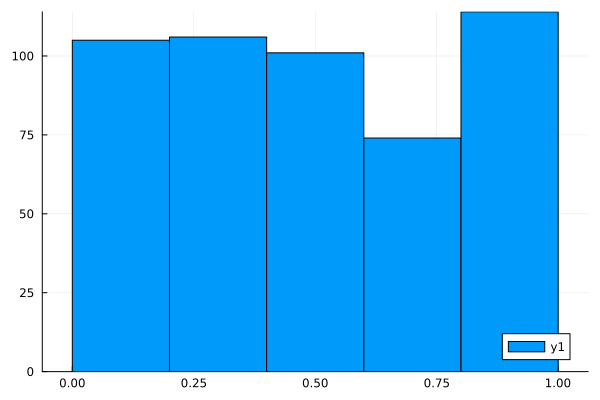

In [8]:
input = generate_input_x(config)

@show typeof(input) size(input)
@show get_parameter_count(config)

#input_cpu = input |> cpu_device()

# plot the inputs is needed

histogram(input[1,:])

In [9]:
# -------------------------------------------------------------------
# Entrenamiento
# -------------------------------------------------------------------
losses = []
NN, Θ, st = create_neural_network(config)


(Chain{@NamedTuple{layer_1::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(1 => 20, tanh), layer_2 = Dense(20 => 20, tanh), layer_3 = Dense(20 => 1)), nothing), (layer_1 = (weight = [-0.9583777189254761; -1.918269157409668; … ; -0.43454018235206604; 2.4057703018188477;;], bias = [0.07076525688171387, -0.1883317232131958, -0.46105337142944336, 0.5916318893432617, 0.4983968734741211, -0.47142791748046875, 0.47980260848999023, -0.9608172178268433, 0.976685643196106, -0.879181981086731, -0.7039589881896973, 0.3546929359436035, -0.13616728782653809, 0.34227311611175537, 0.18438851833343506, 0.7551097869873047, -0.11987197399139404, 0.9066390991210938, 0.6410025358200073, -0.9385449886322021]), layer_2 = (weight = [0.00863209180533886 -0.01959366723895073 … 0.6002421379089355 0.14549212157726288

In [ ]:
@show residual_at_points(input, NN, Θ, st)
@show loss_function(input, NN, Θ, st)

0.7475084539092253

In [11]:


#calculate_Dirichlet_f(input[1:1, :], input[2:2, :], NN, Θ, st)
#f, ∂2f_∂x2, ∂2f_∂t2 = calculate_derivatives_Dirichlet(input[1:1, :], input[2:2, :], NN, Θ, st)

In [20]:
Θ, st, losses = compute_regression(config, input, NN, Θ, st, losses)

# Parámetros optimizados a CPU si procede


 

┌ Info: RAD round 1 / 10  |  iters=500
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:564


Current loss: 0.7475084539092253
Current loss: 0.7133075049125108
Current loss: 0.6801507941710583
Current loss: 0.5211869639618167
Current loss: 0.5133981444213778
Current loss: 0.509638865852135
Current loss: 0.5040519240581064
Current loss: 0.4960198365903949
Current loss: 0.4942141080990139
Current loss: 0.474837201688694
Current loss: 0.4745229074053841
Current loss: 0.47197814226315016
Current loss: 0.47109259533244857
Current loss: 0.46968093532481836
Current loss: 0.4686379565580214
Current loss: 0.4678479615709802
Current loss: 0.46681019277824254
Current loss: 0.46561808475534106
Current loss: 0.4633262491857947
Current loss: 0.43113449013064525
Current loss: 0.43005986655927464
Current loss: 0.4056841921073965
Current loss: 0.4008207866639668
Current loss: 0.399463688868625
Current loss: 0.39723739032851324
Current loss: 0.3942626721737
Current loss: 0.3914343412347462
Current loss: 0.38788706221120356
Current loss: 0.38423620169994815
Current loss: 0.38266126122550287
Curre

┌ Info: RAD round 2 / 10  |  iters=500
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:564


Current loss: 3.108232741808081e-8
Current loss: 2.967615410360821e-8
Current loss: 2.922024241113429e-8
Current loss: 2.9164209040413516e-8
Current loss: 2.9083604496000293e-8
Current loss: 2.9062154302267468e-8
Current loss: 2.900747818669718e-8
Current loss: 2.883584832810992e-8
Current loss: 2.875638469030053e-8
Current loss: 2.8641944403273923e-8
Current loss: 2.861916006349918e-8
Current loss: 2.8360503802064298e-8
Current loss: 2.8009059929849117e-8
Current loss: 2.7789579289883256e-8
Current loss: 2.769468028682067e-8
Current loss: 2.764601577045567e-8
Current loss: 2.76340556679058e-8
Current loss: 2.7604806814772787e-8
Current loss: 2.7415371914810085e-8
Current loss: 2.7363470973269446e-8
Current loss: 2.733064177244017e-8
Current loss: 2.7326342667430502e-8
Current loss: 2.732304262002838e-8
Current loss: 2.7319782110136937e-8
Current loss: 2.7307602766919526e-8
Current loss: 2.7279223813505488e-8
Current loss: 2.727519008912118e-8
Current loss: 2.726111512389915e-8
Current

┌ Info: RAD round 3 / 10  |  iters=500
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:564



Current loss: 3.3857620859292412e-9
Current loss: 3.3775641246870943e-9
Current loss: 3.311047000045924e-9
Current loss: 3.287889393568022e-9
Current loss: 3.2841167830968593e-9
Current loss: 3.2800991676354464e-9
Current loss: 3.2774715986574246e-9
Current loss: 3.26796087331093e-9
Current loss: 3.2585616292245674e-9
Current loss: 3.2457466833491956e-9
Current loss: 3.242164541432039e-9
Current loss: 3.237535146814981e-9
Current loss: 3.236172839873557e-9
Current loss: 3.234558385049348e-9
Current loss: 3.2332176439093358e-9
Current loss: 3.2309783431265558e-9
Current loss: 3.2256085485197156e-9
Current loss: 3.22224848940932e-9
Current loss: 3.1876924886840263e-9
Current loss: 3.1862564713086997e-9
Current loss: 3.174998893203887e-9
Current loss: 3.167253277950305e-9
Current loss: 3.1667875655469932e-9
Current loss: 3.1583810387265903e-9
Current loss: 3.147792921155315e-9
Current loss: 3.144743303703768e-9
Current loss: 3.1402807360171318e-9
Current loss: 3.126824854048125e-9
Curren

┌ Info: RAD round 4 / 10  |  iters=500
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:564



Current loss: 8.775473160061092e-10
Current loss: 8.71879255857592e-10
Current loss: 8.64804326463799e-10
Current loss: 8.470040783822318e-10
Current loss: 8.442830605803179e-10
Current loss: 8.403644079672828e-10
Current loss: 8.304496190986501e-10
Current loss: 8.16593628448351e-10
Current loss: 8.154885931594238e-10
Current loss: 8.150268163846068e-10
Current loss: 8.126247376341317e-10
Current loss: 8.101271340928113e-10
Current loss: 8.07648077491716e-10
Current loss: 8.056529776906474e-10
Current loss: 8.04073274989829e-10
Current loss: 8.022767817698152e-10
Current loss: 8.008867470064842e-10
Current loss: 7.984669163466204e-10
Current loss: 7.97669794294877e-10
Current loss: 7.973181819145344e-10
Current loss: 7.961005586140689e-10
Current loss: 7.940927772022133e-10
Current loss: 7.936881100604823e-10
Current loss: 7.929791157581843e-10
Current loss: 7.928894965335871e-10
Current loss: 7.904822563560893e-10
Current loss: 7.902554029098171e-10
Current loss: 7.900527216897007e-

┌ Info: RAD round 5 / 10  |  iters=500
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:564


3.020685901860211e-10
Current loss: 2.9945391480838413e-10
Current loss: 2.9831187653514486e-10
Current loss: 2.957956107520102e-10
Current loss: 2.9242218809908575e-10
Current loss: 2.910764747291038e-10
Current loss: 2.901765459355624e-10
Current loss: 2.894962593706626e-10
Current loss: 2.8831640211615376e-10
Current loss: 2.865617281736075e-10
Current loss: 2.8425371782109253e-10
Current loss: 2.8212687539431914e-10
Current loss: 2.805629386498033e-10
Current loss: 2.794785139163043e-10
Current loss: 2.7814561103168556e-10
Current loss: 2.777744351857116e-10
Current loss: 2.7679691530240237e-10
Current loss: 2.7659231471782207e-10
Current loss: 2.7654560100234845e-10
Current loss: 2.7649999220834774e-10
Current loss: 2.7635258853831234e-10
Current loss: 2.7607629091022635e-10
Current loss: 2.757979262651904e-10
Current loss: 2.757037892149026e-10
Current loss: 2.7561103701287475e-10
Current loss: 2.7556825497889763e-10
Current loss: 2.7540764717262476e-10
Current loss: 2.7535677206

┌ Info: RAD round 6 / 10  |  iters=500
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:564


1.3160611615419826e-10
Current loss: 1.3101456016887393e-10
Current loss: 1.3048284837131997e-10
Current loss: 1.291310424850002e-10
Current loss: 1.2907913770798163e-10
Current loss: 1.2886546811106902e-10
Current loss: 1.2837410850840714e-10
Current loss: 1.2819568938562565e-10
Current loss: 1.2807771503427425e-10
Current loss: 1.2799224030361345e-10
Current loss: 1.2785369049310814e-10
Current loss: 1.2783863383652266e-10
Current loss: 1.277506570571278e-10
Current loss: 1.277314439198346e-10
Current loss: 1.274224900466288e-10
Current loss: 1.2740041573637366e-10
Current loss: 1.2730306999707847e-10
Current loss: 1.2729237434011505e-10
Current loss: 1.2728673242738813e-10
Current loss: 1.2726799060505696e-10
Current loss: 1.272546830870521e-10
Current loss: 1.272360572818316e-10
Current loss: 1.2722663250710515e-10
Current loss: 1.2717919857843761e-10
Current loss: 1.27021894103341e-10
Current loss: 1.2675084065976158e-10
Current loss: 1.267209122581844e-10
Current loss: 1.26637674

┌ Info: RAD round 7 / 10  |  iters=500
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:564



Current loss: 3.773379396620247e-11
Current loss: 3.7549660552064935e-11
Current loss: 3.7212684705673556e-11
Current loss: 3.717236914550563e-11
Current loss: 3.70273261468881e-11
Current loss: 3.688738525891632e-11
Current loss: 3.670589633458135e-11
Current loss: 3.6687739424257296e-11
Current loss: 3.6597091687188135e-11
Current loss: 3.645043770618761e-11
Current loss: 3.643304305043366e-11
Current loss: 3.642683772222385e-11
Current loss: 3.6421045314219966e-11
Current loss: 3.641363028755591e-11
Current loss: 3.632386687406429e-11
Current loss: 3.632311442406849e-11
Current loss: 3.6314573071806604e-11
Current loss: 3.631192979930421e-11
Current loss: 3.6306341552736254e-11
Current loss: 3.6254910991661e-11
Current loss: 3.62464131009425e-11
Current loss: 3.624279658537798e-11
Current loss: 3.623841027902828e-11
Current loss: 3.6178010646540186e-11
Current loss: 3.612796233574879e-11
Current loss: 3.603686483605515e-11
Current loss: 3.597472050978549e-11
Current loss: 3.5933298

┌ Info: RAD round 8 / 10  |  iters=500
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:564



Current loss: 1.8771825690883155e-11
Current loss: 1.858809128293999e-11
Current loss: 1.8415819618588752e-11
Current loss: 1.8346544923031137e-11
Current loss: 1.832110316249244e-11
Current loss: 1.808493302257751e-11
Current loss: 1.7825810306436893e-11
Current loss: 1.7527975574425467e-11
Current loss: 1.7505882848911197e-11
Current loss: 1.7491519091886567e-11
Current loss: 1.7346191537079297e-11
Current loss: 1.731173390534165e-11
Current loss: 1.725722265997621e-11
Current loss: 1.713192778436422e-11
Current loss: 1.70486087144665e-11
Current loss: 1.6988892674870516e-11
Current loss: 1.6897294121736183e-11
Current loss: 1.6823036446662924e-11
Current loss: 1.6795545423751638e-11
Current loss: 1.6701610258033816e-11
Current loss: 1.6661221723442016e-11
Current loss: 1.6649026499909804e-11
Current loss: 1.6605762393451513e-11
Current loss: 1.659873486369473e-11
Current loss: 1.659283460825308e-11
Current loss: 1.65699443253138e-11
Current loss: 1.656629270621967e-11
Current loss:

┌ Info: RAD round 9 / 10  |  iters=500
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:564


1.014570877966682e-11
Current loss: 9.926517153410722e-12
Current loss: 9.820025026081085e-12
Current loss: 9.808016850111101e-12
Current loss: 9.794735455772064e-12
Current loss: 9.787004966869519e-12
Current loss: 9.734093682140346e-12
Current loss: 9.659074681722072e-12
Current loss: 9.603461483952606e-12
Current loss: 9.550821416893613e-12
Current loss: 9.513397984984765e-12
Current loss: 9.46329293205201e-12
Current loss: 9.411662440708185e-12
Current loss: 9.364206373007197e-12
Current loss: 9.318569219791498e-12
Current loss: 9.303882782262395e-12
Current loss: 9.267671906583641e-12
Current loss: 9.146987493450634e-12
Current loss: 9.129761742406172e-12
Current loss: 9.127851079314585e-12
Current loss: 9.108929711656947e-12
Current loss: 9.10118567890577e-12
Current loss: 9.099115797707934e-12
Current loss: 9.091686116433856e-12
Current loss: 9.088093541055143e-12
Current loss: 9.003146127058713e-12
Current loss: 8.994260201834245e-12
Current loss: 8.988167983170513e-12
Current 

┌ Info: RAD round 10 / 10  |  iters=500
└ @ Main /Users/reula/Julia/PINN/neural_tools.jl:564



Current loss: 1.3827958172228429e-11
Current loss: 1.3592017536672451e-11
Current loss: 1.3461851141956155e-11
Current loss: 1.3390268054410002e-11
Current loss: 1.3333232555011759e-11
Current loss: 1.3249946748517692e-11
Current loss: 1.2916336827789969e-11
Current loss: 1.2730485584890564e-11
Current loss: 1.2482387866060145e-11
Current loss: 1.2409031141461483e-11
Current loss: 1.2306864154536648e-11
Current loss: 1.2182045722032468e-11
Current loss: 1.1987850015544877e-11
Current loss: 1.1742165879329577e-11
Current loss: 1.1568167039482496e-11
Current loss: 1.1499892556041955e-11
Current loss: 1.14269192766685e-11
Current loss: 1.1274286955607199e-11
Current loss: 1.115112318686669e-11
Current loss: 1.0995570111921326e-11
Current loss: 1.0979482530887589e-11
Current loss: 1.090643826213158e-11
Current loss: 1.0903303273248085e-11
Current loss: 1.0874105176032062e-11
Current loss: 1.0815164435791058e-11
Current loss: 1.0797036523873739e-11
Current loss: 1.0598062228918162e-11
Curr

((layer_1 = (weight = [0.7211127152578791; -3.170170613575971; … ; -1.0086209641821358; 4.865760358641202;;], bias = [-0.36323367450621463, -2.2998738056599, -0.17202383068898522, 0.4120988962290708, 1.5433530830262372, -2.515655998875136, 0.40995087987390266, -1.7197796225308595, 2.302790978328988, -0.6264345116080273, -2.165498816477973, 0.6023790920668779, -0.7381610031020248, 0.21176870957360355, -1.0710269427272248, 0.3493789519612427, -0.1098920932551663, -0.34597183383475943, -0.28353379460550193, -3.6181512933617888]), layer_2 = (weight = [1.580774692401183 -0.4828946946423706 … 0.13319503493944443 -4.373097990445278; -1.9225733379030647 0.6237843542573236 … 1.7153278813005828 0.7565225027407655; … ; 0.23501489186554084 -0.06689815358035456 … -0.3684881165012836 0.4748148441806406; 1.9261092587975337 0.6313370581716415 … 1.6824606946285938 1.4182555745261298], bias = [0.9006130627819723, 0.022726928181697345, -0.8856985043234069, -0.9653107869309909, 0.8291172094639053, -0.1542

In [21]:
Θ_cpu = Θ |> cpu_device()

ComponentVector{Float64}(layer_1 = (weight = [0.7211127152578791; -3.170170613575971; … ; -1.0086209641821358; 4.865760358641202;;], bias = [-0.36323367450621463, -2.2998738056599, -0.17202383068898522, 0.4120988962290708, 1.5433530830262372, -2.515655998875136, 0.40995087987390266, -1.7197796225308595, 2.302790978328988, -0.6264345116080273, -2.165498816477973, 0.6023790920668779, -0.7381610031020248, 0.21176870957360355, -1.0710269427272248, 0.3493789519612427, -0.1098920932551663, -0.34597183383475943, -0.28353379460550193, -3.6181512933617888]), layer_2 = (weight = [1.580774692401183 -0.4828946946423706 … 0.13319503493944443 -4.373097990445278; -1.9225733379030647 0.6237843542573236 … 1.7153278813005828 0.7565225027407655; … ; 0.23501489186554084 -0.06689815358035456 … -0.3684881165012836 0.4748148441806406; 1.9261092587975337 0.6313370581716415 … 1.6824606946285938 1.4182555745261298], bias = [0.9006130627819723, 0.022726928181697345, -0.8856985043234069, -0.9653107869309909, 0.82

**Save data:**

In [14]:
println("Training completed. Saving data")
@save "regression_try.jld2" Θ_cpu st config losses

if in_nbinclude()
    exit()
end

Training completed. Saving data


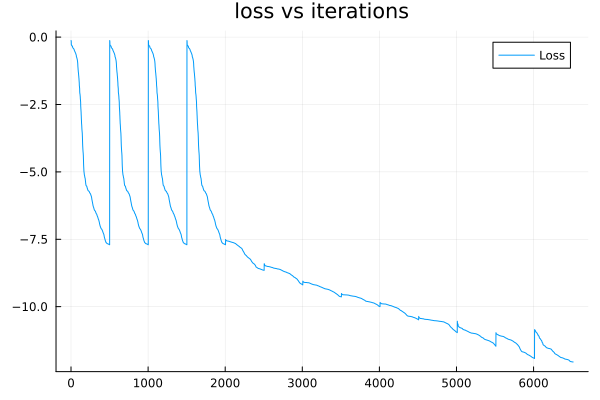

In [22]:
plot(losses, label = "Loss", title = "loss vs iterations") #, yscale = :log10)


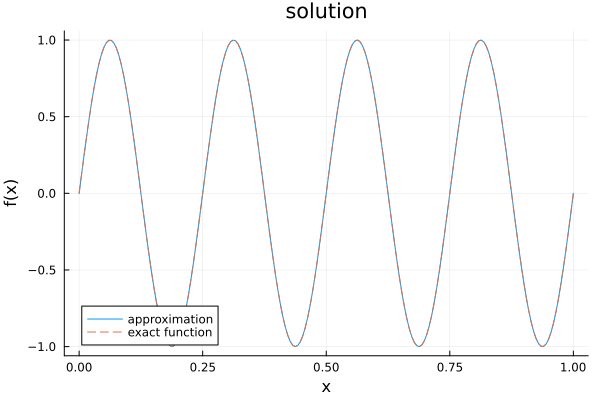

In [23]:
@unpack xmin, xmax, A, B, p = config

xs = reshape(collect(range(config[:xmin], config[:xmax], length=200)), 1, :)
#sol_p = [NN(vcat(x), Θ, st)[1][1] for x in xs[1,:]]
sol_p = NN(vcat(xs), Θ, st)[1]

#sol_p[1,:]
plot(xs[1,:],sol_p[1,:], label = "approximation", title = "solution")
plot!(xs[1,:],f.(xs[1,:]), label = "exact function", linestyle = :dash)  
plot!(xlabel = "x", ylabel = "f(x)")   


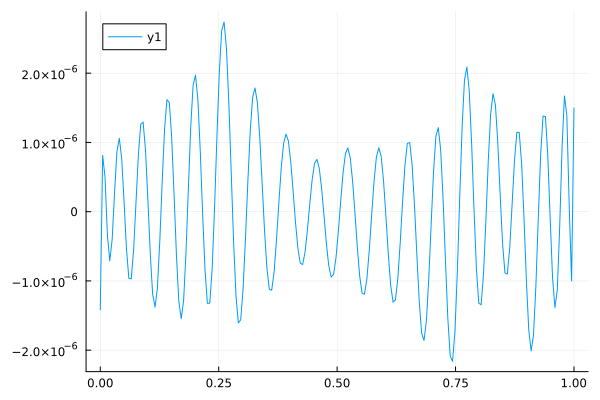

In [24]:
residual_at_points(vcat(xs), NN, Θ, st)[1,:]
plot(xs[1,:],residual_at_points(vcat(xs), NN, Θ, st)[1,:])